In [14]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry


In [24]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5)}
boxsize = {250:51, 350:39, 500:27}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results/'

zbins = [(1., 5.0)]
# zbins = [(0.1, 1.), (1.,2.), (2.,3.), (3.,4.)]#, (4.,5.)]

rmax = 9

In [25]:
bkd = {}
sims = {}
fluxes_bkd = {}

for lambda_ in lambdas:
    bkd[lambda_] = {}
    sims[lambda_] = {}
    fluxes_bkd[lambda_] = {}
    # Loop over patches
    for patch in patches:
            bkd[lambda_][patch] = {}
            sims[lambda_][patch] = {}
            fluxes_bkd[lambda_][patch] = {}
            for idz, (zmin, zmax) in enumerate(zbins):
                sims_ = pickle.load(gzip.open(results_folder + '/patch'+patch+'_lambda'+str(lambda_)+'_zmin'+str(zmin)+'_zmax'+str(zmax)+'.pkl','rb'))
                sims[lambda_][patch][idz] = np.asarray(sims_['maps'])
                bkd_ = pickle.load(gzip.open(results_folder + '/patch'+patch+'_lambda'+str(lambda_)+'_zmin'+str(zmin)+'_zmax'+str(zmax)+'_RND.pkl','rb'))
                bkd[lambda_][patch][idz] = bkd_['maps']
                fluxes_bkd[lambda_][patch] = bkd_['fluxes']

['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']
['noise', 'zbin', 'patch', 'maps', 'nrnd_', 'fluxes', 'lambda']


In [17]:
def GetTotPhotometryFromStacks(lambda_, zbin, r, r_in=None, r_out=None, remove_mean=True, remove_max=False):
    simuls = {}
    for patch in patches:
        simuls[patch] = sims[lambda_][patch][zbin].copy()
        
    if remove_max > 0:
        for patch in patches:
            for _ in xrange(remove_max):
                simuls[patch] = np.delete(simuls[patch], np.argmax(np.mean(simuls[patch], axis=(1,2))), axis=0)

#     print lambda_, zbin, r, np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).shape
    
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).mean(0)
#           stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch].mean())
        else:
#             stacked_map = simuls.mean(axis=0)
            stacked_map = np.concatenate([simuls[patch].copy() for patch in patches], axis=0).mean(0)

        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).mean(0)
        else:
            stacked_map = np.concatenate([simuls[patch].copy() for patch in patches], axis=0).mean(0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    
    return phot_table.field('aperture_sum')[0]

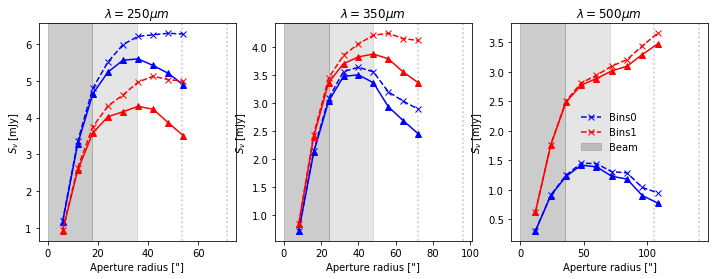

In [18]:
ph_mean = []
ph_mean2 = []
cols = {0:'b', 1:'r', 2:'g', 3:'y', 4:'k', 5:'c'}
j=1
fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for idz in xrange(len(zbins)):
        for i in xrange(1,rmax+1):
            ph_mean.append(GetTotPhotometryFromStacks(lambda_, idz, i, r_in=3*psf[lambda_]/reso[lambda_], r_out=4*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=15))
            ph_mean2.append(GetTotPhotometryFromStacks(lambda_, idz, i, remove_mean=True, remove_max=15))
        
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label='Bins' + str(idz), color=cols[idz])
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'-^', color=cols[idz])

        ph_mean = []
        ph_mean2 = []
              

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)

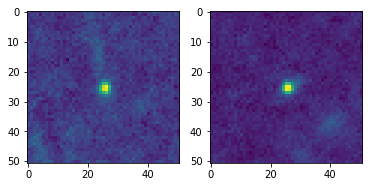

In [19]:
l = 250
plt.subplot(121)
plt.imshow(np.concatenate([sims[l][patch][0].copy() - bkd[l][patch][0].mean() for patch in patches], axis=0).mean(0))
plt.subplot(122)
plt.imshow(np.concatenate([sims[l][patch][1].copy() - bkd[l][patch][1].mean() for patch in patches], axis=0).mean(0))

In [20]:
for i in xrange(2):
    print np.sum([sims[500][p][i].shape[0] for p in patches])

1598
7028


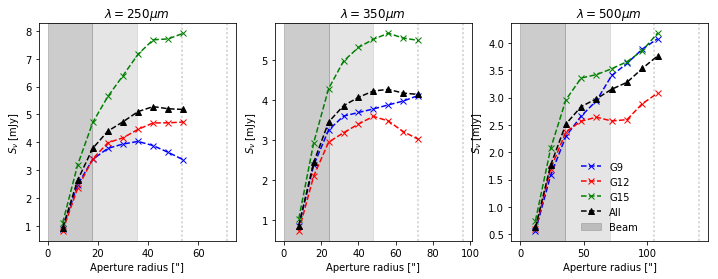

In [7]:
def GetPhotometryFromStacks(lambda_, zbin, patch, r, r_in=None, r_out=None, remove_mean=True, remove_max=0):
#     simuls = {}
#     simuls[patch] = sims[lambda_][patch][zbin].copy()
    simuls = sims[lambda_][patch][zbin].copy()

    if remove_max > 0:
        for _ in xrange(remove_max):
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
       
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = simuls.mean(axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = simuls.mean(axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    return phot_table.field('aperture_sum')[0]

ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 1

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, r_in=3*psf[lambda_]/reso[lambda_], r_out=4*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, r_in=3*psf[lambda_]/reso[lambda_], r_out=4*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'--^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)
    

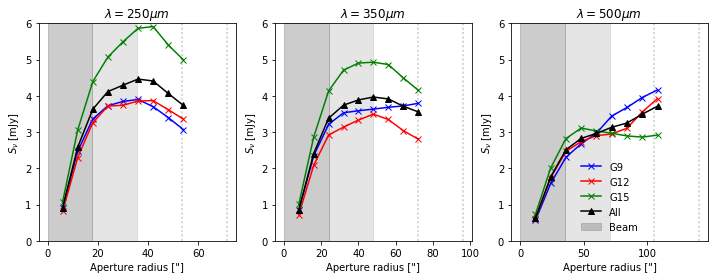

In [10]:
ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 1
rmax = 9

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, remove_mean=True, remove_max=10))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'-x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, remove_mean=True, remove_max=10))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'-^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.ylim([0,6])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)

In [72]:
for lambda_ in lambdas:
    for patch in patches:
        print lambda_, patch, np.std(fluxes_bkd[lambda_][patch])#/np.sqrt(fluxes_bkd[lambda_][patch].shape)

250 G9 25.2104454344
250 G12 24.4027798931
250 G15 35.741765755
350 G9 26.5780795991
350 G12 26.4648588309
350 G15 41.2542489301
500 G9 26.0365255058
500 G12 25.1470807811
500 G15 30.5150907101


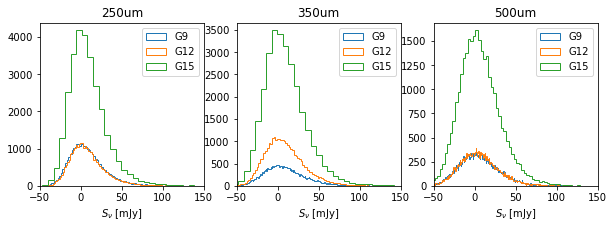

In [31]:
i=1
plt.figure(figsize=(10,3))
for lambda_ in lambdas:
    plt.subplot(1,3,i)
    plt.title(str(lambda_)+'um')
    for patch in patches:
        plt.hist(fluxes_bkd[lambda_][patch],500, histtype='step', label=patch)
    plt.legend()
    plt.xlabel(r'$S_{\nu}$ [mJy]')
    plt.xlim([-50,150])
    i += 1

In [36]:
np.random.choice(np.arange(len(sims[250]['G9'][0])), size=4)

array([2071, 1340,  476, 1926])

In [51]:
def BootstrapErrs(lambda_, patch, zbin, r, r_in=None, r_out=None, remove_mean=True, remove_max=False, nsim=100, nboot=2.):
    simuls = sims[lambda_][patch][zbin].copy()
        
    if remove_max > 0:
        for _ in xrange(remove_max):
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)

    flux = np.zeros(nsim)

    for i in xrange(nsim):
        sims_id = np.random.choice(np.arange(simuls.shape[0]), size=simuls.shape[0]/nboot)
        if (r_in is None) or (r_out is None):
            apertures = CircularAperture(positions[lambda_], r=r)
            if remove_mean:
                stacked_map = (simuls[sims_id].mean(axis=0) - bkd[lambda_][patch][zbin].mean())
            else:
                stacked_map = simuls[sims_id].mean(axis=0)
            phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
        else:
            apertures = CircularAperture(positions[lambda_], r=r)
            annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
            apers = [apertures, annulus_apertures]
            if remove_mean:
                stacked_map = (simuls[sims_id].mean(axis=0) - bkd[lambda_][patch][zbin].mean())
            else:
                stacked_map = simuls[sims_id].mean(axis=0)
            phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
            bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
            bkg_sum = bkg_mean * apertures.area()
            final_sum = phot_table['aperture_sum_0'] - bkg_sum
            phot_table['aperture_sum'] = final_sum

        flux[i] = phot_table.field('aperture_sum')[0]

    return flux

In [63]:
flux = {}
for lambda_ in lambdas:
    flux[lambda_] = {}
    for patch in patches:
        flux[lambda_][patch] = BootstrapErrs(lambda_, patch, 0, 2*psf[lambda_]/reso[lambda_], r_in=None, r_out=None, remove_mean=True, remove_max=10, nsim=1000, nboot=2.)

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(array([  1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   5.,   6.,
          9.,  16.,  28.,  25.,  27.,  40.,  54.,  54.,  61.,  69.,  78.,
         67.,  60.,  55.,  61.,  46.,  50.,  41.,  35.,  23.,  24.,  14.,
         16.,   7.,   8.,   7.,   3.,   3.,   2.]),
 array([ 1.08578515,  1.20556996,  1.32535478,  1.4451396 ,  1.56492441,
         1.68470923,  1.80449405,  1.92427886,  2.04406368,  2.1638485 ,
         2.28363331,  2.40341813,  2.52320295,  2.64298776,  2.76277258,
         2.8825574 ,  3.00234221,  3.12212703,  3.24191185,  3.36169666,
         3.48148148,  3.6012663 ,  3.72105112,  3.84083593,  3.96062075,
         4.08040557,  4.20019038,  4.3199752 ,  4.43976002,  4.55954483,
         4.67932965,  4.79911447,  4.91889928,  5.0386841 ,  5.15846892,
         5.27825373,  5.39803855,  5.51782337,  5.63760818,  5.757393  ,
         5.87717782]),
 <a list of 40 Patch objects>)

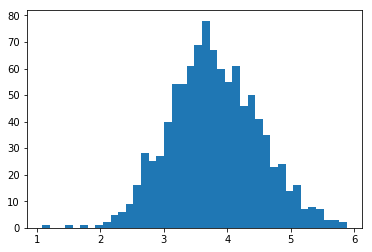

In [62]:
plt.hist(flux, 40)

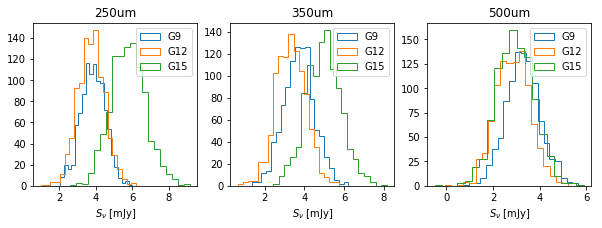

In [66]:
i=1
plt.figure(figsize=(10,3))
for lambda_ in lambdas:
    plt.subplot(1,3,i)
    plt.title(str(lambda_)+'um')
    for patch in patches:
        plt.hist(flux[lambda_][patch],20, histtype='step', label=patch)
    plt.legend()
    plt.xlabel(r'$S_{\nu}$ [mJy]')
#     plt.xlim([-50,150])
    i += 1

In [67]:
flux_an = {}
for lambda_ in lambdas:
    flux_an[lambda_] = {}
    for patch in patches:
        flux_an[lambda_][patch] = BootstrapErrs(lambda_, patch, 0, 2*psf[lambda_]/reso[lambda_], r_in=2*psf[lambda_]/reso[lambda_], r_out=2*np.sqrt(2)*psf[lambda_]/reso[lambda_], remove_mean=True, remove_max=10, nsim=1000, nboot=2.)

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


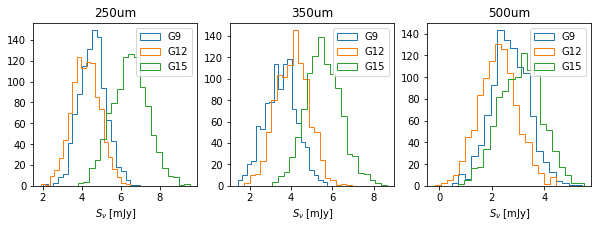

In [68]:
i=1
plt.figure(figsize=(10,3))
for lambda_ in lambdas:
    plt.subplot(1,3,i)
    plt.title(str(lambda_)+'um')
    for patch in patches:
        plt.hist(flux_an[lambda_][patch],20, histtype='step', label=patch)
    plt.legend()
    plt.xlabel(r'$S_{\nu}$ [mJy]')
#     plt.xlim([-50,150])
    i += 1

In [71]:
for lambda_ in lambdas:
    for patch in patches:
        print lambda_, patch, np.std(flux[lambda_][patch])/np.sqrt(2), np.std(flux_an[lambda_][patch])/np.sqrt(2)

250 G9 0.471754684664 0.484289063071
250 G12 0.513274120509 0.506036075357
250 G15 0.670189451209 0.647780053645
350 G9 0.545282928672 0.550482993398
350 G12 0.529145712284 0.550121352393
350 G15 0.610550029517 0.613691370511
500 G9 0.521121351641 0.511020783169
500 G12 0.521726153614 0.521026506677
500 G15 0.567813996977 0.572499416537
